In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from sbi.analysis import pairplot
from sbi.inference import SNPE
from sbi.utils import BoxUniform, posterior_nn
from torch import ones, zeros
import pickle
import matplotlib as mpl

from sbi.analysis import conditional_pairplot
import pickle
import sbi
from sbi.analysis import conditional_corrcoeff
from sbi.analysis import eval_conditional_density
from copy import deepcopy
sys.path.append("../../../arco_sims/adaptive_box_posteriors/")
import bounds

In [3]:
import time

In [4]:
params_name_mapping = {
'ephys.NaTa_t.soma.gNaTa_tbar':'s.Na_t',
'ephys.Nap_Et2.soma.gNap_Et2bar':'s.Na_p',
'ephys.K_Pst.soma.gK_Pstbar':'s.K_p',
'ephys.K_Tst.soma.gK_Tstbar':'s.K_t',
'ephys.SK_E2.soma.gSK_E2bar':'s.SK',
'ephys.SKv3_1.soma.gSKv3_1bar':'s.Kv_3.1',
'ephys.Ca_HVA.soma.gCa_HVAbar':'s.Ca_H',
'ephys.Ca_LVAst.soma.gCa_LVAstbar':'s.Ca_L',
'ephys.CaDynamics_E2.soma.gamma':'s.Y',
'ephys.CaDynamics_E2.soma.decay':'s.T_decay',
 
'ephys.none.soma.g_pas':'s.leak',
'ephys.none.axon.g_pas':'ax.leak',
'ephys.none.dend.g_pas':'b.leak',
'ephys.none.apic.g_pas':'a.leak',
 
'ephys.NaTa_t.axon.gNaTa_tbar':'ax.Na_t',
'ephys.Nap_Et2.axon.gNap_Et2bar':'ax.Na_p',
'ephys.K_Pst.axon.gK_Pstbar':'ax.K_p',
'ephys.K_Tst.axon.gK_Tstbar':'ax.K_t',
'ephys.SK_E2.axon.gSK_E2bar':'ax.SK',
'ephys.SKv3_1.axon.gSKv3_1bar':'ax.Kv_3.1',
'ephys.Ca_HVA.axon.gCa_HVAbar':'ax.Ca_H',
'ephys.Ca_LVAst.axon.gCa_LVAstbar':'ax.Ca_L',
'ephys.CaDynamics_E2.axon.gamma':'ax.Y',
'ephys.CaDynamics_E2.axon.decay':'ax.T_decay',
 
'ephys.Im.apic.gImbar':'a.I_m',
'ephys.NaTa_t.apic.gNaTa_tbar':'a.Na_t',
'ephys.SKv3_1.apic.gSKv3_1bar':'a.Kv_3.1',
'ephys.Ca_HVA.apic.gCa_HVAbar':'a.Ca_H',
'ephys.Ca_LVAst.apic.gCa_LVAstbar':'a.Ca_L',
'ephys.SK_E2.apic.gSK_E2bar':'a.SK',
'ephys.CaDynamics_E2.apic.gamma':'a.Y',
'ephys.CaDynamics_E2.apic.decay':'a.T_decay',
 
'ephys.SKv3_1.apic.offset':'a.Kv_3.1_offset',
'ephys.SKv3_1.apic.slope':'a.Kv_3.1_slope',
'scale_apical.scale': 'a.scale'
}

In [5]:
dataset = np.load(
    "../../../arco_sims/adaptive_box_posteriors/simulation_outputs/theta_and_x.npz",
    allow_pickle=True,
)
theta = dataset["theta"].tolist()
x = dataset["x"].tolist()

In [6]:
xo = torch.tensor([3.1, 3.1, 3.1, 3.1, 3.1, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5])

In [7]:
filepath = "/home/michael/Documents/arco_sims/adaptive_box_posteriors2/88_86940691440007411_0.01.pickle"

with open(filepath, "rb") as handle:
    posterior2 = pickle.load(handle)

In [8]:
samples = posterior2.sample((10000,), x=xo)

# Analyse all morphologies and configurations

In [9]:
names_ = list(params_name_mapping.values())

In [10]:
string_pairs = [
    ["84", "7712997831240842", "0.015"],
    ["85", "1", "0.02"],
    ["85", "5", "0.015"],
    ["86", "6", "0.005"],
    ["86", "707527054352652", "0.01"],
    ["87", "550434680389613", "0.005"],
    ["87", "73418029210004229", "0.005"],
    ["88", "59997244694401254", "0.015"],
    ["88", "86940691440007411", "0.01"],
    ["88", "90233447606250669", "0.005"],
    ["89", "1506562604769867", "0.02"],
    ["89", "49992413252944133", "0.02"],
    ["89", "98394633867104423", "0.025"],
    ["91", "5", "0.03"],
    ["91", "63065090307991878", "0.045"],
    ["93", "49588549670578687", "0.01"],
    ["WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0", "94", "0.01"],
    ["WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0", "96", "0.01"],
    ["WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5", "81", "0.015"],
    ["WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5", "84", "0.03"],
    ["WR69_Cell2_L5TT_mean", "1", "0.005"],
    ["WR69_Cell2_L5TT_mean", "32", "0.01"],
    ["WR69_Cell2_L5TT_medfilt", "1", "0.005"],
    ["WR69_Cell2_L5TT_medfilt", "6", "0.01"],
    ["WR71_Cell6_L5TT_constant_mean", "104", "0.02"],
    ["WR71_Cell6_L5TT_constant_mean", "120", "0.015"],
    ["WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone", "130", "0.015"],
    ["WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone", "136", "0.01"]
]

In [11]:
def load_posterior(str1, str2, str3):

    filepath = f"/home/michael/Documents/arco_sims/adaptive_box_posteriors2/{str1}_{str2}_{str3}.pickle"

    with open(filepath, "rb") as handle:
        posterior = pickle.load(handle)

    all_bounds_ = bounds.bounds_
    bounds_ = all_bounds_[str1, str2]
    upper_ = np.asarray(list(bounds_["max"].values()))
    lower_ = np.asarray(list(bounds_["min"].values()))
    gt_ = np.asarray(list(bounds_["value"].values()))
    limits = np.asarray([lower_, upper_]).T

    condition = torch.as_tensor(gt_, dtype=torch.float32)
    posterior.set_default_x(xo)

    return posterior, condition, limits

In [12]:
posterior, condition, limits = load_posterior(*string_pairs[0])

In [13]:
samples = posterior.sample((10_000,))

In [14]:
interesting_dims = [1, 2, 5, 7, 10, 17, 22, 24, 34]

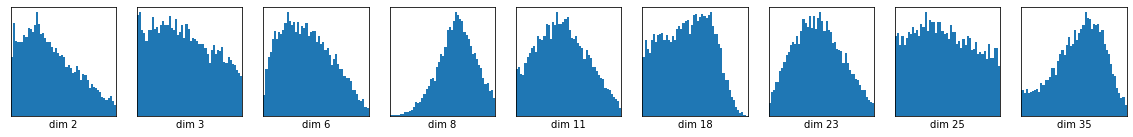

In [15]:
fraction_of_filled_space = []
fig, ax = plt.subplots(1, len(interesting_dims), figsize=(20, 2))
counter = 0
for i in interesting_dims:
    hist_vals = ax[counter].hist(samples[:, i].numpy(), bins=50, range=limits[i])
    hist_vals_bigger_zero = np.asarray(hist_vals[0]) > 0
    number_above_zero = np.sum(hist_vals_bigger_zero)
    fraction_of_filled_space.append(number_above_zero / len(hist_vals[0]))
    ax[counter].set_xlim(limits[i])
    ax[counter].set_yticks([])
    ax[counter].set_xticks([])
    ax[counter].set_xlabel(f"dim {i+1}")
    counter += 1

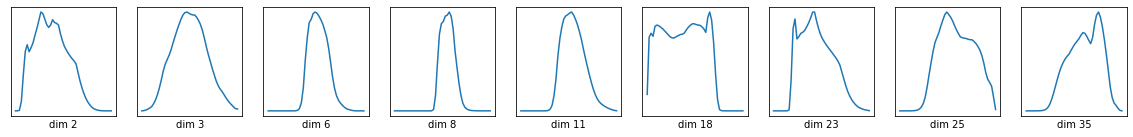

In [16]:
fraction_of_filled_space = []
fig, ax = plt.subplots(1, len(interesting_dims), figsize=(20,2))
counter = 0
limits_diffs = limits[:, 1] - limits[:, 0]
eps_margins = limits_diffs / 1e5
resolution=50
for i in interesting_dims:
    p_vector = eval_conditional_density(
        posterior,
        condition,
        limits,
        i,
        i,
        resolution=resolution,
        eps_margins1=eps_margins[i],
        eps_margins2=eps_margins[i],
    )
    ax[counter].plot(p_vector.numpy())
    ax[counter].set_yticks([])
    ax[counter].set_xticks([])
    ax[counter].set_xlabel(f"dim {i+1}")
    counter += 1

In [17]:
figuresize = 0.9

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


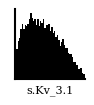

In [18]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(figuresize, figuresize))
    counter = 0

    i = 5
    hist_vals = ax.hist(samples[:, i].numpy(), bins=50, range=limits[i], facecolor='k')
    hist_vals_bigger_zero = np.asarray(hist_vals[0]) > 0
    number_above_zero = np.sum(hist_vals_bigger_zero)
    fraction_of_filled_space.append(number_above_zero / len(hist_vals[0]))
    ax.set_xlim(limits[i])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel(f"dim {i+1}")
    counter += 1
    ax.set_xlabel(names_[i])
    plt.savefig("fig_2a.svg", facecolor='None', transparent=True)

In [46]:
perturbed_condition_bad = deepcopy(condition)
perturbed_condition_good = deepcopy(condition)
perturbed_condition_bad2 = deepcopy(condition)
limitsdiff = limits[i, 1] - limits[i, 0]
perturbed_condition_bad[i] = limits[i,0] + 0.1 * limitsdiff
perturbed_condition_good[i] = limits[i,0] + 0.6 * limitsdiff
perturbed_condition_bad2[i] = limits[i,0] + 0.99 * limitsdiff

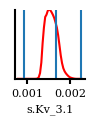

In [47]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(figuresize,figuresize))

    i = 5
    p_vector = eval_conditional_density(
        posterior,
        condition,
        limits,
        i,
        i,
        resolution=resolution,
        eps_margins1=eps_margins[i],
        eps_margins2=eps_margins[i],
        return_raw_log_prob=True
    )
    xvec = torch.linspace(limits[i,0], limits[i,1], 50)
    max_of_pvector = torch.max(p_vector)
    p_vector_exp = torch.exp(p_vector - max_of_pvector)
    ax.plot(xvec.numpy(), p_vector_exp.numpy(), c='r')
#     ax.axvline(condition[i])
    ax.axvline(perturbed_condition_bad[i])
    ax.axvline(perturbed_condition_good[i])
    ax.axvline(perturbed_condition_bad2[i])
    ax.set_yticks([])
#     ax.set_xticks([])

    ax.set_ylim([0.0, torch.max(p_vector_exp).numpy()])
    ax.set_xlabel(names_[i])
    plt.savefig("fig_2b.svg", facecolor='None', transparent=True)

In [36]:
string_pairs[0]

['84', '7712997831240842', '0.015']

In [37]:
perturbed_condition

tensor([ 1.2355e+02,  3.8200e-03,  1.6835e+02,  2.6137e-02,  5.3420e+02,
         9.2715e-04,  1.3597e-03,  5.1639e-05,  4.5197e-04,  2.5355e-02,
         1.7348e-04,  8.4550e-03,  9.0192e-07,  7.8264e-02,  1.4889e-02,
         1.6048e-02,  7.8417e-02,  1.7538e-02,  3.0529e+00,  3.9838e+00,
         9.9281e-03,  3.4436e-03,  5.8394e-04,  3.6291e-02,  3.7769e-03,
         1.0201e-04,  4.4150e-02, -1.0396e+00,  1.9416e+00,  1.1934e+00,
         3.3680e-05,  3.2490e-05,  6.0446e-05,  2.0023e-05,  1.3435e+00])

In [48]:
dict_holding_good_and_bad = {"morphology": [], "parameter_set": [], "good_or_bad": []}

In [49]:
dict_holding_good_and_bad["morphology"].append(string_pairs[0])
dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad.numpy())
dict_holding_good_and_bad["good_or_bad"].append("bad")

dict_holding_good_and_bad["morphology"].append(string_pairs[0])
dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_good.numpy())
dict_holding_good_and_bad["good_or_bad"].append("good")

dict_holding_good_and_bad["morphology"].append(string_pairs[0])
dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad2.numpy())
dict_holding_good_and_bad["good_or_bad"].append("bad")

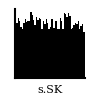

In [51]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(figuresize,figuresize))
    counter = 0

    i = 4
    hist_vals = ax.hist(samples[:, i].numpy(), bins=50, range=limits[i], facecolor='k')
    hist_vals_bigger_zero = np.asarray(hist_vals[0]) > 0
    number_above_zero = np.sum(hist_vals_bigger_zero)
    fraction_of_filled_space.append(number_above_zero / len(hist_vals[0]))
    ax.set_xlim(limits[i])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel(f"dim {i+1}")
    counter += 1
    ax.set_xlabel(names_[i])
    plt.savefig("fig_2c.svg", facecolor='None', transparent=True)

In [54]:
perturbed_condition_bad = deepcopy(condition)
perturbed_condition_good = deepcopy(condition)
perturbed_condition_bad2 = deepcopy(condition)
limitsdiff = limits[i, 1] - limits[i, 0]
perturbed_condition_bad[i] = limits[i,0] + 0.1 * limitsdiff
perturbed_condition_good[i] = limits[i,0] + 0.6 * limitsdiff
perturbed_condition_bad2[i] = limits[i,0] + 0.9 * limitsdiff

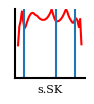

In [55]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(figuresize,figuresize))

    i = 4
    p_vector = eval_conditional_density(
        posterior,
        condition,
        limits,
        i,
        i,
        resolution=resolution,
        eps_margins1=eps_margins[i],
        eps_margins2=eps_margins[i],
        return_raw_log_prob=True
    )
    max_of_pvector = torch.max(p_vector)
    xvec = torch.linspace(limits[i,0], limits[i,1], 50)
    p_vector_exp = torch.exp(p_vector - max_of_pvector)
    ax.plot(xvec.numpy(), p_vector_exp.numpy(), c='r')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axvline(perturbed_condition_bad[i])
    ax.axvline(perturbed_condition_good[i])
    ax.axvline(perturbed_condition_bad2[i])
    

    ax.set_ylim([0.0, torch.max(p_vector_exp).numpy()])
    ax.set_xlabel(names_[i])
    plt.savefig("fig_2d.svg", facecolor='None', transparent=True)

In [56]:
dict_holding_good_and_bad["morphology"].append(string_pairs[0])
dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad.numpy())
dict_holding_good_and_bad["good_or_bad"].append("good")

dict_holding_good_and_bad["morphology"].append(string_pairs[0])
dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_good.numpy())
dict_holding_good_and_bad["good_or_bad"].append("good")

dict_holding_good_and_bad["morphology"].append(string_pairs[0])
dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad2.numpy())
dict_holding_good_and_bad["good_or_bad"].append("good")

In [58]:
def obtain_fraction(posterior, condition, limits):

    fraction_of_marginal = []
    samples = posterior.sample((10_000,))

    for i in range(35):
        hist_vals = np.histogram(samples[:, i].numpy(), bins=50, range=limits[i])
        hist_vals_bigger_zero = np.asarray(hist_vals[0]) > 0
        number_above_zero = np.sum(hist_vals_bigger_zero)
        fraction_of_marginal.append(number_above_zero / len(hist_vals[0]))

    log_prob_of_condition = posterior.log_prob(condition)
    limits_diffs = limits[:, 1] - limits[:, 0]
    eps_margins = limits_diffs / 1e5

    row = 0
    resolution = 50

    all_log_prob_vecs = []
    for row in range(35):
        p_vector = eval_conditional_density(
            posterior,
            condition,
            limits,
            row,
            row,
            resolution=resolution,
            eps_margins1=eps_margins[row],
            eps_margins2=eps_margins[row],
            return_raw_log_prob=True
        )
        all_log_prob_vecs.append(p_vector)
    all_log_prob_vecs = torch.stack(all_log_prob_vecs)

    max_val = log_prob_of_condition
    all_log_prob_vecs_norm = torch.exp(all_log_prob_vecs - max_val)
    scaled_prob_of_condition = torch.exp(log_prob_of_condition - max_val)

    above_thr = all_log_prob_vecs_norm > scaled_prob_of_condition / 20.0
    fractions_1d_cond = torch.sum(above_thr, axis=1) / resolution
    
    return fractions_1d_cond, fraction_of_marginal

In [59]:
all_fractions_1d_cond = []
all_fraction_of_marginal = []

for s in string_pairs:
    print("s", s)
    start_time = time.time()
    posterior, condition, limits = load_posterior(*s)
    fractions_1d_cond, fraction_of_marginal = obtain_fraction(posterior, condition, limits)
    all_fractions_1d_cond.append(fractions_1d_cond.numpy())
    all_fraction_of_marginal.append(np.asarray(fraction_of_marginal))

all_fractions_1d_cond = np.asarray(all_fractions_1d_cond)
all_fraction_of_marginal = np.asarray(all_fraction_of_marginal)

s ['84', '7712997831240842', '0.015']



s ['85', '1', '0.02']



s ['85', '5', '0.015']



s ['86', '6', '0.005']



s ['86', '707527054352652', '0.01']



s ['87', '550434680389613', '0.005']



s ['87', '73418029210004229', '0.005']



s ['88', '59997244694401254', '0.015']



s ['88', '86940691440007411', '0.01']



s ['88', '90233447606250669', '0.005']



s ['89', '1506562604769867', '0.02']



s ['89', '49992413252944133', '0.02']



s ['89', '98394633867104423', '0.025']



s ['91', '5', '0.03']



s ['91', '63065090307991878', '0.045']



s ['93', '49588549670578687', '0.01']



s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0', '94', '0.01']



s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0', '96', '0.01']



s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5', '81', '0.015']



s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5', '84', '0.03']



s ['WR69_Cell2_L5TT_mean', '1', '0.005']



s ['WR69_Cell2_L5TT_mean', '32', '0.01']



s ['WR69_Cell2_L5TT_medfilt', '1', '0.005']



s ['WR69_Cell2_L5TT_medfilt', '6', '0.01']



s ['WR71_Cell6_L5TT_constant_mean', '104', '0.02']



s ['WR71_Cell6_L5TT_constant_mean', '120', '0.015']



s ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone', '130', '0.015']



s ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone', '136', '0.01']


In [60]:
a_names = []
s_names = []
ax_names = []
for i, n in enumerate(names_):
    if n.startswith("s"):
        s_names.append(i)
    if n.startswith("ax"):
        ax_names.append(i)
    elif n.startswith("a"):
        a_names.append(i)

s_names = np.asarray(s_names)
ax_names = np.asarray(ax_names)
a_names = np.asarray(a_names)

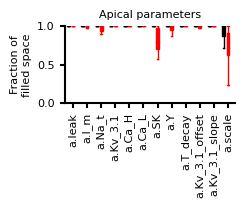

In [61]:
height = 1.0
with mpl.rc_context(fname=".matplotlibrc"):

    fig, ax = plt.subplots(1, 1, figsize=(2.2, height))
    c = 'r'
    ax.boxplot(
        all_fractions_1d_cond[:, a_names],
        positions=np.arange(len(a_names))+1.0,
        widths=0.2, 
        patch_artist=True,
        boxprops=dict(facecolor=c, color=c),
        capprops=dict(color=c),
        whiskerprops=dict(color=c),
        flierprops=dict(color=c, markeredgecolor=c),
        medianprops=dict(color=c),
        showfliers=False
    )
    c = 'k'
    ax.boxplot(
        all_fraction_of_marginal[:, a_names],
        positions=np.arange(len(a_names))-0.3+1.0,
        widths=0.2, 
        patch_artist=True,
        boxprops=dict(facecolor=c, color=c),
        capprops=dict(color=c),
        whiskerprops=dict(color=c),
        flierprops=dict(color=c, markeredgecolor=c),
        medianprops=dict(color=c),
        showfliers=False
    )
#     ax.bar(np.arange(len(a_names))-0.3+1.0, np.asarray(fraction_of_marginal)[a_names], width=0.3)
    ax.set_ylabel("Fraction of\nfilled space")
    ax.set_xlim([0.4, len(a_names)+0.5])
    ax.set_xticks(np.arange(1, 1+len(a_names)))
    ax.set_title("Apical parameters")
    ax.set_ylim([0.0, 1.0])
    ax.set_xticklabels(np.asarray(names_)[a_names], rotation=90)
    plt.savefig("fig_3a.svg", facecolor='None', transparent=True)
    plt.show()

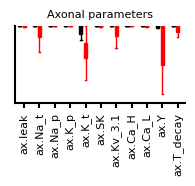

In [62]:
with mpl.rc_context(fname=".matplotlibrc"):

    fig, ax = plt.subplots(1, 1, figsize=(2.2, height))
    c = 'r'
    ax.boxplot(
        all_fractions_1d_cond[:, ax_names],
        positions=np.arange(len(ax_names))+1.0,
        widths=0.2, 
        patch_artist=True,
        boxprops=dict(facecolor=c, color=c),
        capprops=dict(color=c),
        whiskerprops=dict(color=c),
        flierprops=dict(color=c, markeredgecolor=c),
        medianprops=dict(color=c),
        showfliers=False
    )
    c = 'k'
    ax.boxplot(
        all_fraction_of_marginal[:, ax_names],
        positions=np.arange(len(ax_names))-0.3+1.0,
        widths=0.2, 
        patch_artist=True,
        boxprops=dict(facecolor=c, color=c),
        capprops=dict(color=c),
        whiskerprops=dict(color=c),
        flierprops=dict(color=c, markeredgecolor=c),
        medianprops=dict(color=c),
        showfliers=False
    )
#     ax.bar(np.arange(len(a_names))-0.3+1.0, np.asarray(fraction_of_marginal)[a_names], width=0.3)
    ax.set_xlim([0.4, len(ax_names)+0.5])
    ax.set_yticks([])
    ax.set_ylim([0.0, 1.0])
    ax.set_xticks(np.arange(1, 1+len(ax_names)))
    ax.set_title("Axonal parameters")
    ax.set_xticklabels(np.asarray(names_)[ax_names], rotation=90)
    plt.savefig("fig_3b.svg", facecolor='None', transparent=True)
    plt.show()

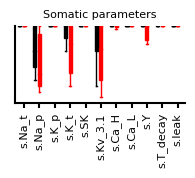

In [63]:
with mpl.rc_context(fname=".matplotlibrc"):

    fig, ax = plt.subplots(1, 1, figsize=(2.2, height))
    c = 'r'
    ax.boxplot(
        all_fractions_1d_cond[:, s_names],
        positions=np.arange(len(s_names))+1.0,
        widths=0.2, 
        patch_artist=True,
        boxprops=dict(facecolor=c, color=c),
        capprops=dict(color=c),
        whiskerprops=dict(color=c),
        flierprops=dict(color=c, markeredgecolor=c),
        medianprops=dict(color=c),
        showfliers=False
    )
    c = 'k'
    ax.boxplot(
        all_fraction_of_marginal[:, s_names],
        positions=np.arange(len(s_names))-0.3+1.0,
        widths=0.2, 
        patch_artist=True,
        boxprops=dict(facecolor=c, color=c),
        capprops=dict(color=c),
        whiskerprops=dict(color=c),
        flierprops=dict(color=c, markeredgecolor=c),
        medianprops=dict(color=c),
        showfliers=False
    )
#     ax.bar(np.arange(len(a_names))-0.3+1.0, np.asarray(fraction_of_marginal)[a_names], width=0.3)
    ax.set_yticks([])
    ax.set_xlim([0.4, len(s_names)+0.5])
    ax.set_ylim([0.0, 1.0])
    ax.set_xticks(np.arange(1, 1+len(s_names)))
    ax.set_title("Somatic parameters")
    ax.set_xticklabels(np.asarray(names_)[s_names], rotation=90)
    plt.savefig("fig_3c.svg", facecolor='None', transparent=True)
    plt.show()

# Moving on to 2D conditionals

### First configuration

In [64]:
posterior, condition, limits = load_posterior(*string_pairs[-1])

dim1 = 29
dim2 = 17
limits_diffs = limits[:, 1] - limits[:, 0]
eps_margins = limits_diffs / 1e5

p_matrix = eval_conditional_density(
    posterior,
    condition,
    limits,
    dim1,
    dim2,
    resolution=resolution,
    eps_margins1=eps_margins[dim1],
    eps_margins2=eps_margins[dim2],
)

In [117]:
limitsdiff1 = limits[dim1, 1] - limits[dim1, 0]
limitsdiff2 = limits[dim2, 1] - limits[dim2, 0]
perturbed_condition_good1 = deepcopy(condition)
perturbed_condition_good2 = deepcopy(condition)
perturbed_condition_good3 = deepcopy(condition)

perturbed_condition_good1[dim1] = limits[dim1,0] + 0.1 * limitsdiff1
perturbed_condition_good1[dim2] = limits[dim2,0] + 0.09 * limitsdiff2

perturbed_condition_good2[dim1] = limits[dim1,0] + 0.5 * limitsdiff1
perturbed_condition_good2[dim2] = limits[dim2,0] + 0.35 * limitsdiff2

perturbed_condition_good3[dim1] = limits[dim1,0] + 0.9 * limitsdiff1
perturbed_condition_good3[dim2] = limits[dim2,0] + 0.62 * limitsdiff2

perturbed_condition_bad1 = deepcopy(condition)
perturbed_condition_bad2 = deepcopy(condition)
perturbed_condition_bad3 = deepcopy(condition)

perturbed_condition_bad1[dim1] = limits[dim1,0] + 0.1 * limitsdiff1
perturbed_condition_bad1[dim2] = limits[dim2,0] + 0.62 * limitsdiff2

perturbed_condition_bad2[dim1] = limits[dim1,0] + 0.9 * limitsdiff1
perturbed_condition_bad2[dim2] = limits[dim2,0] + 0.09 * limitsdiff2

perturbed_condition_bad3[dim1] = limits[dim1,0] + 0.1 * limitsdiff1
perturbed_condition_bad3[dim2] = limits[dim2,0] + 0.9 * limitsdiff2

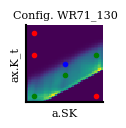

In [119]:
with mpl.rc_context(fname=".matplotlibrc"):

    fig, ax = plt.subplots(1, 1, figsize=(3.5, height))
    plt.imshow(p_matrix, origin="lower", extent=[limits[dim1, 0], limits[dim1, 1], limits[dim2, 0], limits[dim2, 1]], aspect=50)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(names_[dim1])
    ax.set_ylabel(names_[dim2])
#     ax.set_xlim(limits[dim1])
#     ax.set_ylim(limits[dim2])
    ax.scatter(condition[dim1], condition[dim2], c='b')
    ax.scatter(perturbed_condition_good1[dim1], perturbed_condition_good1[dim2], c='g')
    ax.scatter(perturbed_condition_good2[dim1], perturbed_condition_good2[dim2], c='g')
    ax.scatter(perturbed_condition_good3[dim1], perturbed_condition_good3[dim2], c='g')
    ax.scatter(perturbed_condition_bad1[dim1], perturbed_condition_bad1[dim2], c='r')
    ax.scatter(perturbed_condition_bad2[dim1], perturbed_condition_bad2[dim2], c='r')
    ax.scatter(perturbed_condition_bad3[dim1], perturbed_condition_bad3[dim2], c='r')
    
    ax.set_title("Config. WR71_130")
    plt.savefig("fig_4a.svg", facecolor='None', transparent=True)

In [120]:
# dict_holding_good_and_bad["morphology"].append(string_pairs[-1])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_good1.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("good")

# dict_holding_good_and_bad["morphology"].append(string_pairs[-1])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_good2.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("good")

# dict_holding_good_and_bad["morphology"].append(string_pairs[-1])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_good3.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("good")

# dict_holding_good_and_bad["morphology"].append(string_pairs[-1])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad1.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("bad")

# dict_holding_good_and_bad["morphology"].append(string_pairs[-1])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad2.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("bad")

# dict_holding_good_and_bad["morphology"].append(string_pairs[-1])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad3.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("bad")

### Second configuration

In [122]:
posterior, condition, limits = load_posterior(*string_pairs[-2])

dim1 = 29
dim2 = 17
limits_diffs = limits[:, 1] - limits[:, 0]
eps_margins = limits_diffs / 1e5

p_matrix = eval_conditional_density(
    posterior,
    condition,
    limits,
    dim1,
    dim2,
    resolution=resolution,
    eps_margins1=eps_margins[dim1],
    eps_margins2=eps_margins[dim2],
)

In [144]:
limitsdiff1 = limits[dim1, 1] - limits[dim1, 0]
limitsdiff2 = limits[dim2, 1] - limits[dim2, 0]
perturbed_condition_good1 = deepcopy(condition)
perturbed_condition_good2 = deepcopy(condition)
perturbed_condition_good3 = deepcopy(condition)

perturbed_condition_good1[dim1] = limits[dim1,0] + 0.15 * limitsdiff1
perturbed_condition_good1[dim2] = limits[dim2,0] + 0.12 * limitsdiff2

perturbed_condition_good2[dim1] = limits[dim1,0] + 0.5 * limitsdiff1
perturbed_condition_good2[dim2] = limits[dim2,0] + 0.35 * limitsdiff2

perturbed_condition_good3[dim1] = limits[dim1,0] + 0.9 * limitsdiff1
perturbed_condition_good3[dim2] = limits[dim2,0] + 0.68 * limitsdiff2

perturbed_condition_bad1 = deepcopy(condition)
perturbed_condition_bad2 = deepcopy(condition)
perturbed_condition_bad3 = deepcopy(condition)

perturbed_condition_bad1[dim1] = limits[dim1,0] + 0.15 * limitsdiff1
perturbed_condition_bad1[dim2] = limits[dim2,0] + 0.68 * limitsdiff2

perturbed_condition_bad2[dim1] = limits[dim1,0] + 0.9 * limitsdiff1
perturbed_condition_bad2[dim2] = limits[dim2,0] + 0.07 * limitsdiff2

perturbed_condition_bad3[dim1] = limits[dim1,0] + 0.15 * limitsdiff1
perturbed_condition_bad3[dim2] = limits[dim2,0] + 0.9 * limitsdiff2

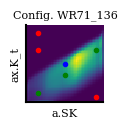

In [145]:
with mpl.rc_context(fname=".matplotlibrc"):

    fig, ax = plt.subplots(1, 1, figsize=(3.5, height))
    plt.imshow(p_matrix, origin="lower", extent=[limits[dim1, 0], limits[dim1, 1], limits[dim2, 0], limits[dim2, 1]], aspect=50)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(names_[dim1])
    ax.set_ylabel(names_[dim2])
    ax.set_title("Config. WR71_136")
    ax.scatter(condition[dim1], condition[dim2], c='b')
    ax.scatter(perturbed_condition_good1[dim1], perturbed_condition_good1[dim2], c='g')
    ax.scatter(perturbed_condition_good2[dim1], perturbed_condition_good2[dim2], c='g')
    ax.scatter(perturbed_condition_good3[dim1], perturbed_condition_good3[dim2], c='g')
    ax.scatter(perturbed_condition_bad1[dim1], perturbed_condition_bad1[dim2], c='r')
    ax.scatter(perturbed_condition_bad2[dim1], perturbed_condition_bad2[dim2], c='r')
    ax.scatter(perturbed_condition_bad3[dim1], perturbed_condition_bad3[dim2], c='r')
    plt.savefig("fig_4b.svg", facecolor='None', transparent=True)

In [146]:
# dict_holding_good_and_bad["morphology"].append(string_pairs[-1])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_good1.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("good")

# dict_holding_good_and_bad["morphology"].append(string_pairs[-1])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_good2.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("good")

# dict_holding_good_and_bad["morphology"].append(string_pairs[-1])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_good3.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("good")

# dict_holding_good_and_bad["morphology"].append(string_pairs[-1])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad1.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("bad")

# dict_holding_good_and_bad["morphology"].append(string_pairs[-1])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad2.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("bad")

# dict_holding_good_and_bad["morphology"].append(string_pairs[-1])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad3.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("bad")

### Different morphology

In [147]:
posterior, condition, limits = load_posterior(*string_pairs[-16])

dim1 = 29
dim2 = 17
limits_diffs = limits[:, 1] - limits[:, 0]
eps_margins = limits_diffs / 1e5

p_matrix = eval_conditional_density(
    posterior,
    condition,
    limits,
    dim1,
    dim2,
    resolution=resolution,
    eps_margins1=eps_margins[dim1],
    eps_margins2=eps_margins[dim2],
)

In [162]:
limitsdiff1 = limits[dim1, 1] - limits[dim1, 0]
limitsdiff2 = limits[dim2, 1] - limits[dim2, 0]
perturbed_condition_good1 = deepcopy(condition)
perturbed_condition_good2 = deepcopy(condition)
perturbed_condition_good3 = deepcopy(condition)

perturbed_condition_good1[dim1] = limits[dim1,0] + 0.45 * limitsdiff1
perturbed_condition_good1[dim2] = limits[dim2,0] + 0.18 * limitsdiff2

perturbed_condition_good2[dim1] = limits[dim1,0] + 0.55 * limitsdiff1
perturbed_condition_good2[dim2] = limits[dim2,0] + 0.35 * limitsdiff2

perturbed_condition_good3[dim1] = limits[dim1,0] + 0.9 * limitsdiff1
perturbed_condition_good3[dim2] = limits[dim2,0] + 0.68 * limitsdiff2

perturbed_condition_bad1 = deepcopy(condition)
perturbed_condition_bad2 = deepcopy(condition)
perturbed_condition_bad3 = deepcopy(condition)

perturbed_condition_bad1[dim1] = limits[dim1,0] + 0.15 * limitsdiff1
perturbed_condition_bad1[dim2] = limits[dim2,0] + 0.68 * limitsdiff2

perturbed_condition_bad2[dim1] = limits[dim1,0] + 0.3 * limitsdiff1
perturbed_condition_bad2[dim2] = limits[dim2,0] + 0.6 * limitsdiff2

perturbed_condition_bad3[dim1] = limits[dim1,0] + 0.15 * limitsdiff1
perturbed_condition_bad3[dim2] = limits[dim2,0] + 0.9 * limitsdiff2

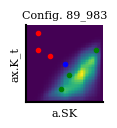

In [163]:
with mpl.rc_context(fname=".matplotlibrc"):

    fig, ax = plt.subplots(1, 1, figsize=(3.5, height))
    plt.imshow(p_matrix, origin="lower", extent=[limits[dim1, 0], limits[dim1, 1], limits[dim2, 0], limits[dim2, 1]], aspect=50)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(names_[dim1])
    ax.set_ylabel(names_[dim2])
    ax.set_title("Config. 89_983")
    ax.scatter(condition[dim1], condition[dim2], c='b')
    ax.scatter(perturbed_condition_good1[dim1], perturbed_condition_good1[dim2], c='g')
    ax.scatter(perturbed_condition_good2[dim1], perturbed_condition_good2[dim2], c='g')
    ax.scatter(perturbed_condition_good3[dim1], perturbed_condition_good3[dim2], c='g')
    ax.scatter(perturbed_condition_bad1[dim1], perturbed_condition_bad1[dim2], c='r')
    ax.scatter(perturbed_condition_bad2[dim1], perturbed_condition_bad2[dim2], c='r')
    ax.scatter(perturbed_condition_bad3[dim1], perturbed_condition_bad3[dim2], c='r')
    plt.savefig("fig_4c.svg", facecolor='None', transparent=True)

In [166]:
# np.save("validation_dict.npy", dict_holding_good_and_bad)

In [175]:
dict_holding_good_and_bad = np.load("validation_dict.npy", allow_pickle=True).tolist()

In [176]:
dict_holding_good_and_bad

{'morphology': [['84', '7712997831240842', '0.015'],
  ['84', '7712997831240842', '0.015'],
  ['84', '7712997831240842', '0.015'],
  ['84', '7712997831240842', '0.015'],
  ['84', '7712997831240842', '0.015'],
  ['84', '7712997831240842', '0.015'],
  ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone',
   '136',
   '0.01'],
  ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone',
   '136',
   '0.01'],
  ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone',
   '136',
   '0.01'],
  ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone',
   '136',
   '0.01'],
  ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone',
   '136',
   '0.01'],
  ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone',
   '136',
   '0.01'],
  ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone',
   '136',
   '0.01'],
  ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone',
   '136',
   '0.01'],
  ['WR71_Cell6_L5TT_constant_mean_exclud

In [165]:
with open("validation_dict.pkl", dict_holding_good_and_bad

{'morphology': [['84', '7712997831240842', '0.015'],
  ['84', '7712997831240842', '0.015'],
  ['84', '7712997831240842', '0.015'],
  ['84', '7712997831240842', '0.015'],
  ['84', '7712997831240842', '0.015'],
  ['84', '7712997831240842', '0.015'],
  ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone',
   '136',
   '0.01'],
  ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone',
   '136',
   '0.01'],
  ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone',
   '136',
   '0.01'],
  ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone',
   '136',
   '0.01'],
  ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone',
   '136',
   '0.01'],
  ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone',
   '136',
   '0.01'],
  ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone',
   '136',
   '0.01'],
  ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone',
   '136',
   '0.01'],
  ['WR71_Cell6_L5TT_constant_mean_exclud

In [164]:
# dict_holding_good_and_bad["morphology"].append(string_pairs[-16])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_good1.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("good")

# dict_holding_good_and_bad["morphology"].append(string_pairs[-16])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_good2.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("good")

# dict_holding_good_and_bad["morphology"].append(string_pairs[-16])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_good3.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("good")

# dict_holding_good_and_bad["morphology"].append(string_pairs[-16])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad1.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("bad")

# dict_holding_good_and_bad["morphology"].append(string_pairs[-16])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad2.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("bad")

# dict_holding_good_and_bad["morphology"].append(string_pairs[-16])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad3.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("bad")

### Analyse correlation

In [142]:
all_corrcoeffs_ = np.load("all_corrcoeffs.npy")

In [573]:
most_interesting = ["s.Na_p", "s.K_t", "s.Kv_3.1", "ax.K_t", "ax.Y", "a.SK", "a.scale"]
most_interesting = ["s.Na_p", "s.K_t", "s.Kv_3.1", "ax.K_t", "ax.Y", "a.SK", "a.scale"]
most_interesting= ["a.SK", "a.scale", "ax.K_t", "ax.Y", "s.Na_p", "s.K_t", "s.Kv_3.1"]
second_most = ["s.Y", "ax.Na_t", "ax.Kv_3.1"]

In [574]:
inds = [names_.index(m) for m in most_interesting]

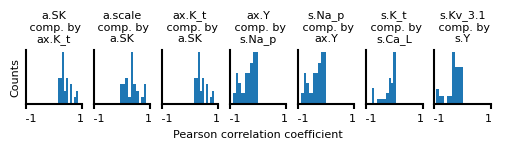

In [586]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, len(inds), figsize=(6, 0.7))
    for counter, i in enumerate(inds):
        average_corrcoeff = np.mean(all_corrcoeffs_, axis=0)
        average_corrcoeff[average_corrcoeff == 1.0] = 0.0

        best_mechanism = np.argmax(np.abs(average_corrcoeff[i]))

        all_comp_correlations = all_corrcoeffs_[:, i, best_mechanism]
        ax[counter].hist(all_comp_correlations)
        ax[counter].set_xlim([-1,1])
        ax[counter].set_title(names_[i]+"\n comp. by\n"+names_[best_mechanism])
        ax[counter].set_yticks([])
        ax[counter].set_xticks([-1, 1])
        ax[counter].set_xticklabels(["   -1", "1 "])
    ax[0].set_ylabel("Counts")
    ax[3].set_xlabel("Pearson correlation coefficient")
#     plt.subplots_adjust(wspace=0.4)
    plt.savefig("fig_5.svg", facecolor='None', transparent=True)
    plt.show()

In [604]:
ax.hist(all_comp_correlations[indicators_band])


AttributeError: 'numpy.ndarray' object has no attribute 'hist'

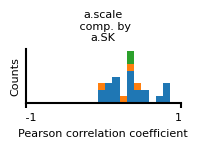

In [609]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 0.7))
    average_corrcoeff = np.mean(all_corrcoeffs_, axis=0)
    average_corrcoeff[average_corrcoeff == 1.0] = 0.0

    best_mechanism = np.argmax(np.abs(average_corrcoeff[i]))

    all_comp_correlations = all_corrcoeffs_[:, i, best_mechanism]
    indicators = [5, 6, 8, 9, 11, 16]
    indicators_lower = [6, 8, 9, 11]
    indicators_upper = [5, 16]
    indicators_band = [0,1,2,3,4,7,10,12,13,14,15,17,18,19,20,21,22,23,24,25,26,27]
    
    ax.hist([all_comp_correlations[indicators_band], all_comp_correlations[indicators_lower], all_comp_correlations[indicators_upper]], stacked=True)
    ax.set_xlim([-1,1])
    ax.set_title(names_[i]+"\n comp. by\n"+names_[best_mechanism])
    ax.set_yticks([])
    ax.set_xticks([-1, 1])
    ax.set_xticklabels(["   -1", "1 "])
    ax.set_ylabel("Counts")
    ax.set_xlabel("Pearson correlation coefficient")
    plt.savefig("stacked_hist.png", dpi=200, bbox_inches="tight")
    plt.show()

### Assemble figure

In [587]:
import IPython.display as IPd
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [600]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "9.4cm",
           
    Panel(
          SVG("fig_2a.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("Marginal", 4.5*factor_svg, 0.0*factor_svg, **kwargs_text8pt),
          Text("a", -2.0*factor_svg, -1.6*factor_svg, **kwargs_text),
    ).move(3*factor_svg, 4*factor_svg),
           
    Panel(
          SVG("fig_2b.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("Conditional", 3.4*factor_svg, 0.0*factor_svg, **kwargs_text8pt),
    ).move(20*factor_svg, 4*factor_svg),
           
    Panel(
          SVG("fig_2c.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(3*factor_svg, 20*factor_svg),
           
    Panel(
          SVG("fig_2d.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(20*factor_svg, 20*factor_svg),
           
    Panel(
          SVG("fig_3a.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("b", 0.0*factor_svg, 1.6*factor_svg, **kwargs_text),
    ).move(39*factor_svg, 1*factor_svg),

    Panel(
          SVG("fig_3b.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(78*factor_svg, 1*factor_svg),

    Panel(
          SVG("fig_3c.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(109*factor_svg, 1*factor_svg),

    Panel(
          SVG("fig_4a.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", 0.0*factor_svg, 1.6*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 42*factor_svg),

    Panel(
          SVG("fig_4b.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(18*factor_svg, 42*factor_svg),

    Panel(
          SVG("fig_4c.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(36*factor_svg, 42*factor_svg),

    Panel(
          SVG("fig_5.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("d", 0.0*factor_svg, 2.6*factor_svg, **kwargs_text),
    ).move(58.5*factor_svg, 41*factor_svg),

)

!mkdir -p fig
f.save("fig/fig1.svg")
svg('fig/fig1.svg')

### Analyse conditional correlations

In [138]:
def obtain_conditional_corrcoeff(str1, str2, str3):

    filepath = f"/home/michael/Documents/arco_sims/adaptive_box_posteriors2/{str1}_{str2}_{str3}.pickle"

    with open(filepath, "rb") as handle:
        posterior = pickle.load(handle)

    all_bounds_ = bounds.bounds_
    bounds_ = all_bounds_[str1, str2]
    upper_ = np.asarray(list(bounds_["max"].values()))
    lower_ = np.asarray(list(bounds_["min"].values()))
    gt_ = np.asarray(list(bounds_["value"].values()))
    limits = np.asarray([lower_, upper_]).T

    condition = torch.as_tensor(gt_, dtype=torch.float32)
    posterior.set_default_x(xo)

    corrcoeff = conditional_corrcoeff(posterior, condition=condition, limits=torch.as_tensor(limits, dtype=torch.float32))
    return corrcoeff

In [139]:
all_corrcoeffs = []

for s in string_pairs:
    print("s", s)
    start_time = time.time()
    corrcoeff_ = obtain_conditional_corrcoeff(*s)
    all_corrcoeffs.append(corrcoeff_.numpy())

all_corrcoeffs = np.asarray(all_corrcoeffs)
# np.save("all_corrcoeffs.npy", all_corrcoeffs)

s ['84', '7712997831240842', '0.015']
s ['85', '1', '0.02']
s ['85', '5', '0.015']
s ['86', '6', '0.005']
s ['86', '707527054352652', '0.01']
s ['87', '550434680389613', '0.005']
s ['87', '73418029210004229', '0.005']
s ['88', '59997244694401254', '0.015']
s ['88', '86940691440007411', '0.01']
s ['88', '90233447606250669', '0.005']
s ['89', '1506562604769867', '0.02']
s ['89', '49992413252944133', '0.02']
s ['89', '98394633867104423', '0.025']
s ['91', '5', '0.03']
s ['91', '63065090307991878', '0.045']
s ['93', '49588549670578687', '0.01']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0', '94', '0.01']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0', '96', '0.01']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5', '81', '0.015']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5', '84', '0.03']
s ['WR69_Cell2_L5TT_mean', '1', '0.005']
s ['WR69_Cell2_L5TT_mean', '32', '0.01']
s ['WR69_Cell2_L5TT_medfilt', '1', '0.005']
s ['WR69_Cell2_L5TT_medfilt', '6', '0.01']
s ['WR71_Ce

### Plot average matrix

In [143]:
mean_coeffs = np.mean(all_corrcoeffs_, axis=0)

<ipython-input-295-1577c8e7f59a>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(names_, rotation=90)


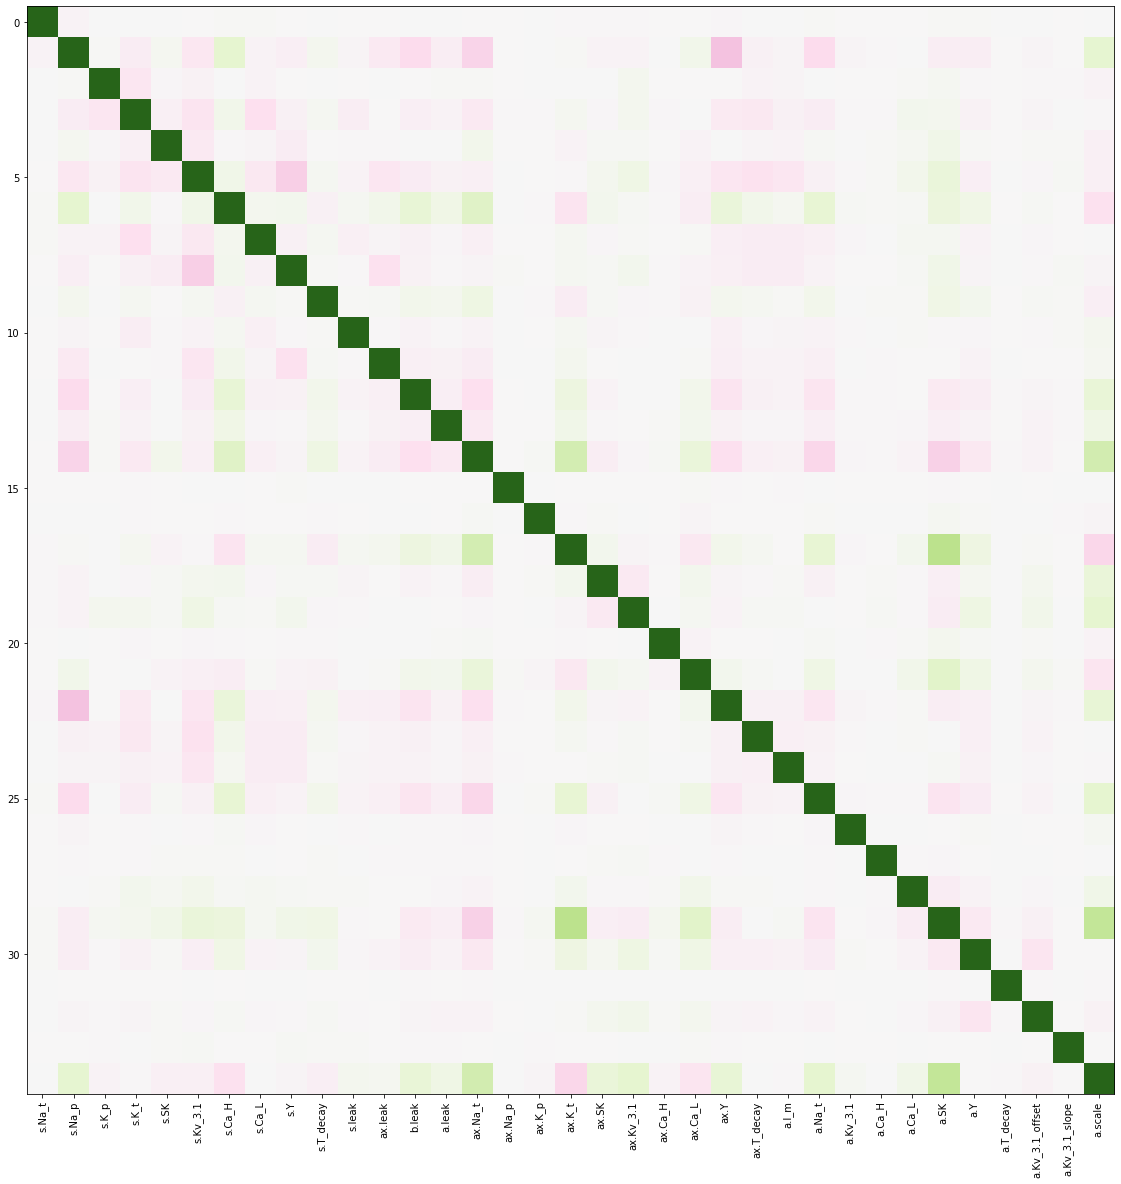

In [295]:
fig, ax = plt.subplots(1, 1, figsize=(20,20))
_ = ax.imshow(mean_coeffs, clim=[-1, 1], cmap='PiYG')
_ = ax.set_xticklabels(names_, rotation=90)
ax.set_xticks(range(35))
plt.savefig("average_condcoeff.png", dpi=200, bbox_inches="tight", facecolor='w')

### Search for the ones with the highest mean

In [155]:
cutoff = 0.25

In [156]:
mean_coeffs_no_diag = np.triu(mean_coeffs, 1)
max_inds = np.abs(mean_coeffs_no_diag) > cutoff
print("Numer of fulfilled: ", np.sum(max_inds))

Numer of fulfilled:  8


In [158]:
num_dims = 35
all_strong_coeffs = []
all_strong_names = []
for col in range(num_dims):
    for row in range(num_dims):
        if max_inds[col, row]:
            strong_coeffs = all_corrcoeffs_[:, col, row]
            strong_cor_names = [names_[col], names_[row]]
            all_strong_coeffs.append(strong_coeffs)
            all_strong_names.append(strong_cor_names)

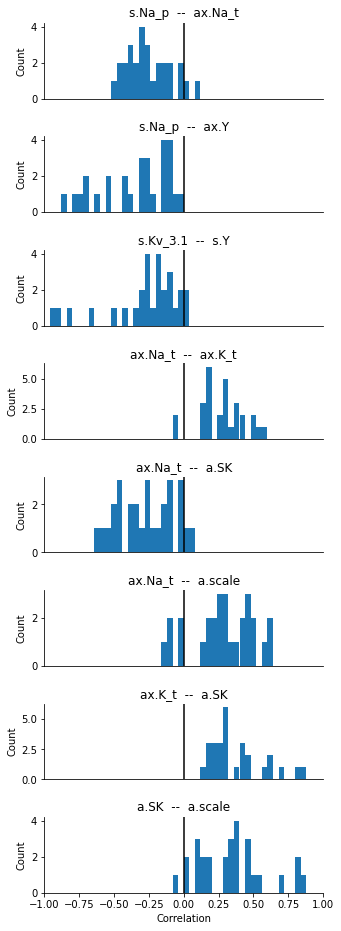

In [294]:
fig, ax = plt.subplots(len(all_strong_coeffs), 1, figsize=(5, 2*len(all_strong_coeffs)))
i = 0
for c, n in zip(all_strong_coeffs, all_strong_names):
    ax[i].hist(c, range=(-1.0, 1.0), bins=50)
    ax[i].set_title(n[0]+"  --  "+n[1])
    ax[i].set_ylabel("Count")
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xlim([-1.0, 1.0])
    ax[i].axvline(0.0, c='k')
    if i < len(all_strong_coeffs) -1:
        ax[i].set_xticks([])
    else:
        ax[i].set_xlabel("Correlation")
    i += 1
plt.subplots_adjust(hspace=0.5)
plt.savefig("maintained_correlations.png", dpi=200, bbox_inches="tight", facecolor='w')
plt.show()

start_time 50.55253195762634


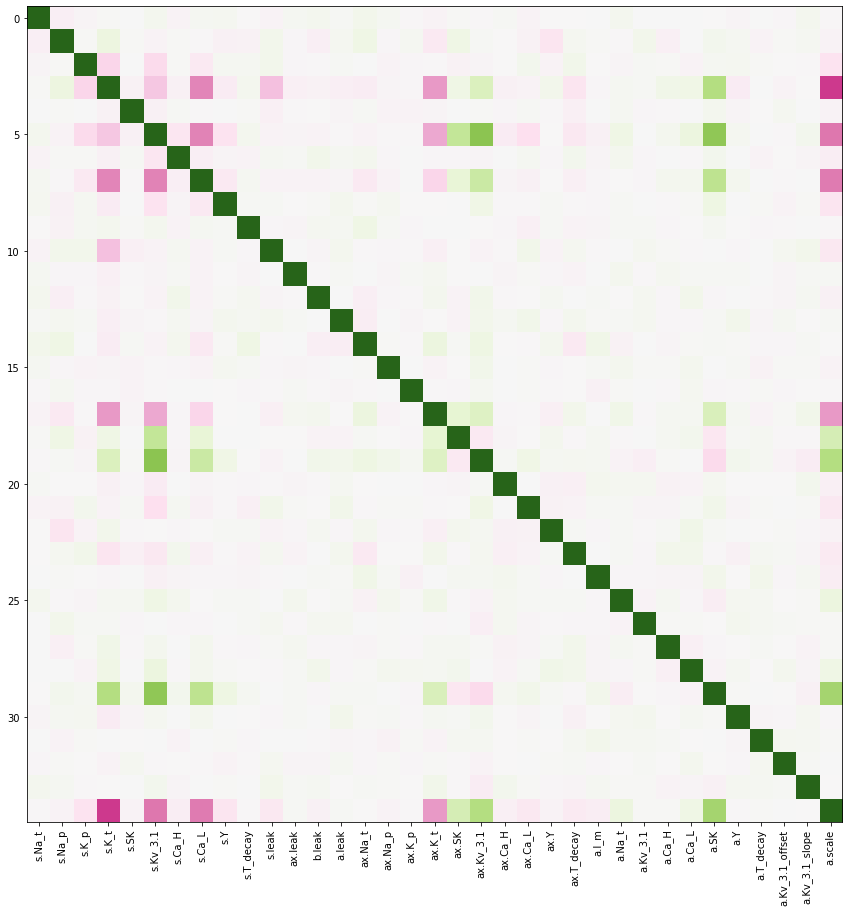

In [41]:
start_time = time.time()
corrcoeff_ = obtain_conditional_corrcoeff("88", "86940691440007411", "0.01")
print("start_time", time.time()-start_time)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
_ = ax.imshow(corrcoeff_, clim=[-1, 1], cmap='PiYG')
_ = ax.set_xticks(range(35))
_ = ax.set_xticklabels(names_, rotation=90)